# Introduction

Text analysis lies at the heart of many interesting and important machine learning problems today. These kinds of problems include things like text classification (determining which genre a novel belongs to), authorship attribution (determining which individual authored an unknown piece of text), spam detection (determining which emails are likely spam), and sentiment analysis (identifying the positive or negative tone attributed to a piece of text). Sentiment analysis in particular has gained a place of great importance in the business world in recent years, and for good reason - it can be a very profitable endeavor!

With the continued rise in popularity of social media like Facebook, Twitter, and Instagram over the last decade, businesses have gained access to enormous amounts of potentially profitable data that have never been available before to any previous generation. Twitter, in particular, has been instrumental in allowing businesses to interact directly with their customers and new consumers around the world in real time. As such, sentiment analysis can allow businesses to quickly identify and understand consumer attitude toward particular products, marketing strategies, etc., without the arduous task of directly polling many thousands of individuals. Analyzing consumer sentiment relating to certain goods can give businesses a competitive advantage over their rivals, allowing them to quickly identify new products that may be well-received, or pin-pointing possible improvements on existing products, thereby increasing profits significantly.

In this post I develop and detail an algorithm to identify the sentiment of tweets sent by U.S. airline travelers. This algorithm follows a naive Bayes approach under a "bag of words" assumption. I find that the classifier works quite well, correctly identifying tweet sentiment about 87% of the time.

Before we take a look at the code, let's go through a brief introduction of Naive Bayes classification and see how we can use it to identify tweet sentiment.

# Naive Bayes Classification

In this post, we are interested in classifying the sentiment of tweets sent by U.S. airline travelers. The sentiment of a tweet refers to the "tone" or "feelings" associated with the text. Sentiment can be classified as being either positive, negative, or neutral. An example tweet for each of these cases is given below.

* Positive: What a great flight. I had a lot of fun!
* Negative: Awful service. Flight was delayed again.
* Neutral: Leaving Las Angeles in one hour.

The first tweet (positive) conveys the feeling that the sender is happy and has had a good traveling experience, while the second tweet (negative) conveys a feeling of anger or dissatisfaction with the airline service. The third tweet (neutral) conveys no sentiment; there is no identifiable positive or negative feeling or tone associated with it. To keep things simple, we will only be interested in binary classification in this post — that is, classifying sentiment as being either "positive" or "negative". To categorize these tweets, we'll be using something called a naive Bayes classifier.

The naive Bayes classifier relies on the Bayesian approach of conditional probabilities. The Bayesian approach to computing probabilities is based on Bayes' theorem, which can be stated mathematically as

$$P(A\vert B) = \frac{P(B\vert A)P(A)}{P(B)},$$

where A and B are two different events. From [this](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) source,

* $P(A)$ and $P(B)$ are the probabilities of observing events A and B without regard to each other.
* $P(A\vert B)$, a conditional probability, is the probability of observing event A given that B is true.
* $P(B\vert A)$ is the probability of observing event B given that A is true.

As described above, the Bayesian approach is conditional in the sense that probabilities are computed based on "degrees of belief" of certain occurrences that contribute to a final probability we're trying to compute. For example, the U.S. has a population of about 320 million people at the present time. If we are told that 32 million people currently living in the U.S. will be diagnosed with cancer at some point in their lives, we might expect our own chances of developing cancer at some point are 10%. However, such a simple calculation does not take into account several important factors which may lead to a better probability estimate. For example, what if some people are smokers? What if some people do not exercise reagularly, or are generally unhealthy? As a toy example, let's compute the probability of an individual being diagnosed with cancer given that they smoke regularly. In this case, the terms in the equation above would be

* $P(A\vert B)$, the probability of getting cancer (event A) given that an individual is a smoker (event B).
* $P(B\vert A)$, the probability that an individual diagnosed with cancer is a smoker.
* $P(A)$, the probability of anyone (smoker or not) being diagnosed with cancer.
* $P(B)$, the probability that an individual is a smoker.

For this example, let's suppose that the probability that an individual diagnosed with cancer is a smoker is 60%, and that 20% of the U.S. population are smokers. We then compute the probability of a smoker being diagnosed with cancer as

$$P(cancer\vert smoker) = \frac{P(smoker\vert cancer)P(cancer)}{P(smoker)} = \frac{0.6\times0.1}{0.2} = 30\%,$$

or triple the population cancer diagnosis probability of 10%. Of course this is a very simple example, but hopefully it gets the point across.

The "naive" part of the naive Bayes classifier comes from the assumption that features describing a particular object are independent of one another. For example, say you had a set of unlabeled animals that you wanted to classify as either being a chicken or a horse. Each animal has two defining features that one could use to classify them — weight and color. Here, it's safe to assume that the weight feature is independent of the color feature, and vice versa. In other words, the weight of an animal has no bearing on what its color might be, and its color has no bearing on how much the animal weighs. Of course this is a simple example, and the relationship between multiple variables in a real life classification situation is not always so clear-cut.

In classifying tweet text, we will be relying on a "bag of words" approach. This means that we treat all tweets of a given labeled class as being a giant unordered group (or "bag") of words. When presented with an unlabeled tweet to classify, we will look at its individual words and compare the number of times they occur in the "positive" bag to the number times they occur in the "negative" bag. If the words occur more often in the positive bag, we simply label the tweet sentiment as being "positive", while if they occur more often in the negative bag, the tweet is labeled as being "negative". In other words, we are interested only in word frequency in our classification. To compute the probability of a tweet belonging to a particular class $c$, we take Bayes' theorem and rewrite it as

$$\hat{c} = \mathrm{argmax_{c}} \frac{P(t\vert c)P(c)}{P(t)}.$$

We can also make the simplification that $P(t\vert c)$, the probability of tweet $t$ being in class $c$, can be represented by the probability of its individual words being in $c$. Mathematically, this can be written as

$$P(t\vert c) = P(w_1\vert c) \cdot P(w_2\vert c) \cdot \ldots \cdot P(w_n\vert c),$$

where $w_i$ is the $i^{\rm{th}}$ word in the tweet, and $n$ is the total number of words in the tweet. Combining the last two equations, we get

$$\hat{c} = \mathrm{argmax_{c}} P(c)\big[P(w_1\vert c) \cdot P(w_2\vert c) \cdot \ldots \cdot P(w_n\vert c)\big].$$

Or, more compactly,

$$\hat{c} = \mathrm{argmax_{c}} P(c) \prod_{i=1}^{n} P(w_i\vert c).$$

# Training the Classifier

Okay, now that we have the procedure written down mathematically, let's put everything together and describe how to train the classifier. In order to compute $\hat{c}$ for an unlabeled tweet, we need to compute the two terms $P(c)$ and

$$\prod_{i=1}^{n} P(w_i\vert c).$$

To compute the "prior", $P(c)$, we simply have to compute the fraction of tweets in our training set that are of class $c$. This can be written as

$$P(c) = \frac{N_c}{N_t},$$

where $N_c$ is the number of tweets of class $c$, and $N_t$ is the total number of tweets in the training set. To find the term

$$\prod_{i=1}^{n} P(w_i\vert c),$$

we have to compute $P(w_i\vert c)$, the frequency of word $w_i$ in class $c$. To do this, we calculate

$$P(w_i\vert c) = \frac{count(w_i,c)}{\sum_v count(w,c)}.$$

In this equation, the numerator represents the number of times word $w_i$ appears in class $c$, and the denominator represents the total number of words in $c$. In some cases, we'll find that a new unclassified tweet contains a word that is not in the training set at all. In that case the numerator goes to zero, and since our method dictates that we multiply individual word probabilitites together, the overall probability of a tweet being in class $c$ automatically goes to zero. To get around this, we can introduce a Laplace smoothing factor so that even if a word is not contained in class $c$, we can still compute a non-zero probability value. We therefore modify the above equation to look like

$$P(w_i\vert c) = \frac{count(w_i,c)+1}{\sum_v count(w,c)+N_v}.$$

Notice that even if $count(w_i,c)$ is zero, the $+1$ term keeps $P(w_i\vert c)$ from going to zero. The denominator also contains a new term, $N_v$. This is called the vocabulary &#8212; the number of unique words in the full training set. So to summarize, before we can classify a new tweet, we need to train the classifier. During the training procedure, we must compute

* The priors, $P(c)$, for each class $c$.
* The list of all words in each class $c$.
* The number of unique words in the training set (the vocabulary).

Okay, now that we have some understanding of how the classifier works, we can go on and explore the data!

# Tweet Data

Let's start by loading in the appropriate Python libraries and reading in the tweet data. We then grab only data columns *text* and *airline_sentiment*.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as mp
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
stop = stopwords.words('english')

tweets = pd.read_csv('/Users/degrave/DataScience/site/sentiment/twitter-airline-sentiment/Tweets.csv')

df = tweets[['airline_sentiment','text']]

Let's start by taking a look at the data.

In [29]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We can see the data contain information regarding the the names of various U.S. airline companies, the text contained in each user's tweet, tweet sentiment (postive, negative, or neutral), the reason for any negative sentiment toward a particular airline, user location where available, etc. Here, we will try and identify tweet sentiment based solely on the text of the tweet, ignoring all other data columns.

At the moment, the full set of 14,640 tweets is comprised of 2,363 positive ones, 9,178 negative ones, and 3,099 neutral ones. The code snippet belows allows us to define the number of different classes we'll divide the tweets into. In this particular post, we are only interested in binary classification; in other words classifying tweets as either positive or negative, ignoring the neutral ones. We therefore set n_class = 2. We can also define the number of tweets per class we'll use in our training set. If the classes have a very different number of tweets (i.e., the classes are imbalanced) it is often the case that the algorithm will learn that always guessing the more prevalent class (the negative class in our case) is a good thing to do, and will subsequently misclassify many of the positive instances. Because the positive and negative classes are imbalanced in our case, we'll downsample the negative class to be the same size as the positive one.

In [30]:
def getData(df, nclass):
    if nclass == 2:
        df_pos = df[df['airline_sentiment'] == 'positive']
        df_neg = df[df['airline_sentiment'] == 'negative'].sample(n=len(df_pos), random_state=0)

        df = pd.concat([df_pos, df_neg], ignore_index=True).reset_index(drop=True)
        #df['airline_sentiment'].replace('positive', 0, inplace=True)
        #df['airline_sentiment'].replace('negative', 1, inplace=True)

    elif nclass == 3:
        df_pos = df[df['airline_sentiment'] == 'positive']
        df_neg = df[df['airline_sentiment'] == 'negative'].sample(n=len(df_pos), random_state=0)
        df_neu = df[df['airline_sentiment'] == 'neutral'].sample(n=len(df_pos), random_state=0)

        df = pd.concat([df_pos, df_neg, df_neu], ignore_index=True).reset_index(drop=True)
        #df['airline_sentiment'].replace('positive', 0, inplace=True)
        #df['airline_sentiment'].replace('negative', 1, inplace=True)
        #df['airline_sentiment'].replace('negative', 1, inplace=True)
    return df

df = getData(df, 2)

# Processing the Data

Before we can start classifying tweets, we first need to clean them up a little bit. One may note that tweets in their raw form can be quite messy; they contain several forms of punctuation, capitalizations, url links, etc. Remember, we are only interested in looking at specific words and their usage here, so these things matter to us. To this end, we can define a couple of functions that we'll use to process all the tweets in our dataset. The first function, processText, takes in a tweet and strips away all punctuation, special characters, and extra white space. It also replaces any instance of *www* or *http* with the term *urlsite*, and makes all words lowercase.

The second function, rmStopWords, removes stop words from each tweet. Stop words are words that, even though they're common in speech, really don't convey any sentiment or feeling. These include words like "at", "and", "the", etc. The function splits a tweet into its individual word tokens and checks to see if any of the words are in a pre-defined stop word list.

In [31]:
def processText(text):
    text = text.lower().strip()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\r', ' ', text)
    text = re.sub('((www\S+)|(http\S+))', 'urlsite', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub('[\W]+', ' ', text)
    text = re.sub(r' +', ' ', text).strip()
    return text

def rmStopWords(text):
    text = [i for i in text.split() if i not in stop]
    return ' '.join(text)

Let's run our tweets through the two functions.

In [32]:
df['textPro'] = df['text'].apply(processText).apply(rmStopWords)

We can check out the processed data.

In [33]:
df.head()

,airline_sentiment,text,textPro
0,positive,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercials experienc...
1,positive,"@VirginAmerica yes, nearly every time I fly VX...",virginamerica yes nearly every time fly vx ear...
2,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",virginamerica well
3,positive,"@VirginAmerica it was amazing, and arrived an ...",virginamerica amazing arrived hour early good
4,positive,@VirginAmerica I &lt;3 pretty graphics. so muc...,virginamerica lt 3 pretty graphics much better...


Now that the data has been processed, we have to split it up into separate training and test sets. Generally, for a given set of data, about two thirds is randomly chosen and placed in the training set, while the other one third is reserved for the test set. Since our tweet dataset isn't very large, we'll use an 80-20 split instead. Fortunately for us, Python's Scikit-Learn package has a nice built-in method called *train_test_split* that allows us to divide the data in one call.

In [ ]:
Xtr, Xte = train_test_split(df, test_size=0.2, random_state=0)

# The Tweet Classifier
Okay, now the fun part! Below we define our own Python class called TweetNBClassifier which allows us to fit the classifier on our training data, predict the sentiment of each tweet (positive or negative), and score our results (i.e., determine how many tweets we've classified correctly). The class works sort of like a container for the various functions we'll need. We'll go through each section of the classifier and describe what it does.

In [128]:
class TweetNBClassifier:

    def fit(self, X):
        self.df_pos = X[X['airline_sentiment'] == 'positive']
        self.df_neg = X[X['airline_sentiment'] == 'negative']
        self.df_neu = X[X['airline_sentiment'] == 'neutral']

        Pr_pos = self.df_pos.shape[0]/X.shape[0]
        Pr_neg = self.df_neg.shape[0]/X.shape[0]
        Pr_neu = self.df_neu.shape[0]/X.shape[0]
        self.Prior  = (Pr_pos, Pr_neg, Pr_neu)

        self.pos_words = ' '.join(self.df_pos['text']).split()
        self.neg_words = ' '.join(self.df_neg['text']).split()
        self.neu_words = ' '.join(self.df_neu['text']).split()

        all_words = ' '.join(X['text'].tolist()).split()

        self.vocab = len(Counter(all_words))

        wc_pos = len(' '.join(self.df_pos['text']).split())
        wc_neg = len(' '.join(self.df_neg['text']).split())
        wc_neu = len(' '.join(self.df_neu['text']).split())
        self.word_count = (wc_pos, wc_neg, wc_neu)
        return self

    def predict(self, X):
        class_choice = ['positive', 'negative', 'neutral']

        classification = []
        for tweet in X['text']:
            text = tweet.split()

            val_pos = np.array([])
            val_neg = np.array([])
            val_neu = np.array([])
            for word in text:
                tmp_pos = np.log(self.pos_words.count(word)+1)
                tmp_neg = np.log(self.neg_words.count(word)+1)
                tmp_neu = np.log(self.neu_words.count(word)+1)
                val_pos = np.append(val_pos, tmp_pos)
                val_neg = np.append(val_neg, tmp_neg)
                val_neu = np.append(val_neu, tmp_neu)

            denom_pos = len(text)*np.log(self.word_count[0]+self.vocab)
            denom_neg = len(text)*np.log(self.word_count[1]+self.vocab)
            denom_neu = len(text)*np.log(self.word_count[2]+self.vocab)

            val_pos = np.log(self.Prior[0]) + np.sum(val_pos) - denom_pos
            val_neg = np.log(self.Prior[1]) + np.sum(val_neg) - denom_neg
            val_neu = np.log(self.Prior[2]) + np.sum(val_neu) - denom_neu

            probability = (val_pos, val_neg, val_neu)
            classification.append(class_choice[np.argmax(probability)])
        return classification

    def score(self, feature, target):
        comp_c, comp_i = (0,0)
        tp, tn, fp, fn = (0,0,0,0)

        for i in range(0,len(feature)):
            if feature[i] == target[i]:
                comp_c += 1
                if (target[i] == 'positive') & (feature[i] == 'positive'): tp += 1
            else:
                comp_i += 1
                if (target[i] == 'positive') & (feature[i] == 'negative'): fn += 1
                if (target[i] == 'negative') & (feature[i] == 'positive'): fp += 1

        accuracy = comp_c/(comp_c + comp_i)
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        return accuracy, precision, recall

Once instantiated, the TweetNBClassifier *fit* function takes in only one argument when called - the training dataset. The *fit* function proceeds to create variables that will be used in it and the *predict* and *score* functions below it. The training dataset is divided into separate dataframes for the positive, negative, and neutral tweets. Since we're only interested in doing a binary classification here, the dataframe neutral-tweet dataframe is empty.

The first few lines of the fit function compute the Bayesian prior probabilities necessary for classification as described in the section above (i.e., the number of tweets in each class divided by the total number of tweets in the training set). Directly below this, we compute the number of words in each of the positive, negative, and neutral dataframes. Variable *all_words* collects every word in the training set, while variable *vocab* finds the number of <i>unique</i> words. This is referred to as the "vocabulary" of the data. Lastly, *wc_pos*, *wc_neg*, and *wc_neu* count the total number of words in the three dataframes.

The predict function loops through all tweets in our test dataset, and uses the fit values computed above to predict which class each belongs to. To do this, each tweet is first split into its individual word components and, for each word in the tweet, we compute the fractions

$$P(w_i\vert c) = \log \Big[ \frac{count(w_i,c)+1}{\sum_{w\in V}count(w,c) + |V|} \Big]$$

and add them together. Whichever class has the larger probability is then chosen as the predicted class. A nice worked example of this procedure can be found [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf).

Lastly, the score function scores our results in terms of how many tweets we classify correctly. To do this, we loop over each of the classification labels that our algorithm has produced, and compare them to the known labels of the test data. The fraction of correct tweets is then given as our accuracy score.

Okay, let's run the classifier and see how well we do on our test data!

In [121]:
tnb = TweetNBClassifier()
tnb = tnb.fit(Xtr)

predict = tnb.predict(Xte)

In [123]:
accuracy, precision, recall = tnb.score(predict, Xte['airline_sentiment'].tolist())

print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.8699788583509513
precision: 0.8901345291479821
recall: 0.8428874734607219


After running the model, we see that the score function outputs three values. The first value is the accuracy score which suggests that we are able to correctly classify U.S. Airline tweet sentiment approximately 87% of the time! Not bad at all! The other two values refer to the precision and recall respectively. These terms will be discussed in more detail below. Let's first take a look at the confusion matrix.

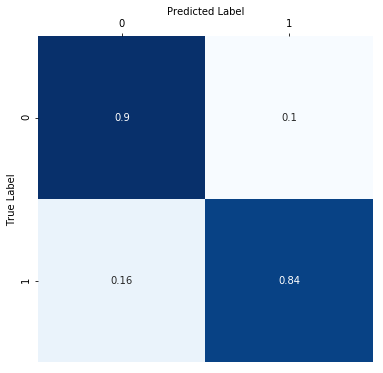

In [145]:
cm = confusion_matrix(Xte['airline_sentiment'], predict)
cm = cm.astype('float')/cm.sum(axis=1)

fig, ax = mp.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False);
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

The confusion matrix shows that the false positive and false negative rates are, as we had hoped, fairly small. We see, too, that the false negative rate is quite a bit larger than the false positive rate, meaning that we more often label a positive tweet as having negative sentiment. Perhaps the negative tweets contain more highly descriptive words like "awful", "hate", "angry", etc., so that our algorithm is able to more easily classify them.

Let's now describe what precision and recall are using the description of a confusion matrix shown below.

<img src="https://github.com/degravek/notebooks/blob/master/images/confusionmatrix.png?raw=true" width="80%">

The x-axis of the table represents all of the tweets our algorithm predicted to be either positive or negative, while the y-axis represents all of the tweets in our test dataset with *actual* positive or negative labels. Inside the table, we see the terms "true positive", "false positive", "true negative", and "false negative". These are defined as

* True positive: Tweets that our algorithm correctly classified as having positive sentiment.
* False positive: Tweets that our algorithm incorrectly identified as having positive sentiment.
* True negative: Tweets that our algorithm correctly classified as having negative sentiment.
* False negative: Tweets that our algorithm incorrectly identified as having negative sentiment.

So, in our case, precision refers to the fraction of tweets that our algorithm classified as positive which were in fact actually positive according to the labels in the test dataset. In other words, of all the tweets classified as being positive, how many of these were actually correct? Precision is computed as

$$\rm{Precision} = \frac{true\,positives}{true\,positives + false\,positives} = 89\%.$$

Similarly, recall answers the question "of all of the positive tweets in the test set, how many did we classify correctly?" Recall is computed as

$$\rm{Recall} = \frac{true\,positives}{true\,positives + false\,negatives} = 84\%.$$

# Concluding Remarks

In this post we took a detailed look at the simple, yet powerful Naive Bayes classifier, and developed an algorithm to accurately classify the sentiment of U.S. Airline tweets. We found that the classifier correctly identified tweet sentiment about 87% of the time. However, there are still several improvements we could make to this algorithm. Text classification performance can sometimes be improved by using a "binary approach" - in other words, simply looking at whether or not a word exists in a tweet rather than its frequency (the number of times it's used). We could also adapt the algorithm to account for negation, which is often observed in real speech. For example, the tweet "That flight was really bad" has a different sentiment than "That flight was really not that bad". Additionally, in terms of examining how well the code generalizes, we could include a way to perform cross-validation to check that our accuracy, precision, and recall will hold up when presented with new, unseen data.

Well, that's all I have for now. Thanks for following along!

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>